Полезные ссылки:

https://arxiv.org/pdf/1703.00409.pdf

https://www.kaggle.com/datasets/mrmorj/alfabattle-20

https://russianblogs.com/article/7983252215/

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 199 kB 59.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=0d5d3cb6207e6a55ca5c26adcb5d3a1a8477195ba2815b5b8488f8c40e30aca4
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [1]:
import pyspark
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from matplotlib import cm
from pyspark.sql.functions import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from plotly.offline import iplot, init_notebook_mode
from pyspark.sql.types import BooleanType, IntegerType, LongType, StringType, ArrayType, FloatType, StructType, StructField, DoubleType

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
spark = SparkSession.builder \
    .appName('EDA_and_kmeans') \
    .getOrCreate()
spark

In [4]:
!wget -O 'sample_data.parquet' -q 'https://www.dropbox.com/s/k9boylaem69x8vn/part_000_0_to_23646.parquet?dl=0'

In [5]:
df = spark.read.parquet('sample_data.parquet')

In [6]:
df.count()

5408648

In [7]:
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- amnt: double (nullable = true)
 |-- currency: integer (nullable = true)
 |-- operation_kind: integer (nullable = true)
 |-- card_type: integer (nullable = true)
 |-- operation_type: integer (nullable = true)
 |-- operation_type_group: integer (nullable = true)
 |-- ecommerce_flag: integer (nullable = true)
 |-- payment_system: integer (nullable = true)
 |-- income_flag: integer (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- country: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- mcc_category: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- days_before: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- hour_diff: long (nullable = true)
 |-- transaction_number: integer (nullable = true)
 |-- __index_level_0__: long (nullable = true)



<b> 0. Дадим описание колонкам в датафрейме

* app_id - Идентификатор заявки. заявки пронумерованы так, что более поздним заявкам соответствует более поздняя дата
* amnt - Нормированная сумма транзакции. 0.0 - соответствует пропускам
* currency - Идентификатор валюты транзакции
* operation_kind - Идентификатор типа транзакции
* card_type - Уникальный идентификатор типа карты
* operation_type - Идентификатор типа операции по пластиковой карте
* operationtypegroup - Идентификатор группы карточных операций, например, дебетовая карта или кредитная карта
* ecommerce_flag - Признак электронной коммерции
* payment_system - Идентификатор типа платежной системы
* income_flag - Признак списания/внесения денежных средств на карту
* mcc - Уникальный идентификатор типа торговой точки
* country - Идентификатор страны транзакции
* city - Идентификатор города транзакции
* mcc_category - Идентификатор категории магазина транзакции
* day_of_week - День недели, когда транзакция была совершена
* hour - Час, когда транзакция была совершена
* days_before - Количество дней до даты выдачи кредита
* weekofyear - Номер недели в году, когда транзакция была совершена
* hour_diff - Количество часов с момента прошлой транзакции для данного клиента
* transaction_number - Порядковый номер транзакции клиента

In [7]:
mcc_df = df['app_id', 'amnt', 'mcc', 'mcc_category', 'day_of_week']

In [8]:
nan_stat_df = mcc_df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in mcc_df.columns])
nan_stat_df.show()

+------+----+---+------------+-----------+
|app_id|amnt|mcc|mcc_category|day_of_week|
+------+----+---+------------+-----------+
|     0|   0|  0|           0|          0|
+------+----+---+------------+-----------+



<b>1. Посмотрим, сколько всего уникальных значений mcc:

In [9]:
len(df.select('mcc').distinct().collect())

108

<b>2. Отсортируем их по частоте встречаемости и оставим только те коды, которые встречаются более 10000 раз:

In [10]:
most_frequent_mcc_lst = [int(row.mcc) for row in mcc_df.groupBy("mcc").count().sort(col("count").desc()).filter(col("count") > 10000).select(col('mcc')).collect()]

In [11]:
mcc_df = mcc_df.filter(col("mcc").isin(most_frequent_mcc_lst))
mcc_df.count()

5167817

<b>3. Проведем разведочный анализ данных:

* <i> Построим график частотности 20-ти наиболее распространненых mcc-кодов

In [13]:
pd_mcc_df = mcc_df['amnt', 'mcc', 'day_of_week'].toPandas()

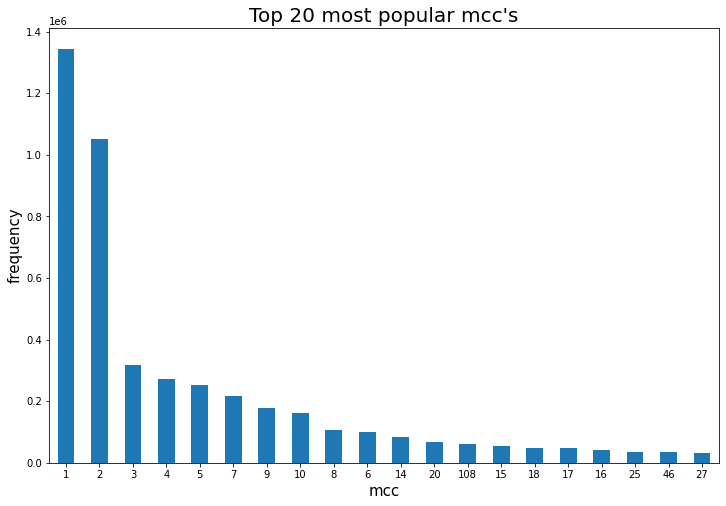

In [14]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xlabel('mcc', fontsize=15)
plt.ylabel('frequency', fontsize=15)
plt.title("Top 20 most popular mcc's", fontsize=20);
pd_mcc_df.groupby('mcc').size().sort_values(ascending=False)[:20].plot(kind='bar', rot=0);

In [15]:
n = 20
pd_mcc_df['mcc'].value_counts()[:n].index.tolist()

[1, 2, 3, 4, 5, 7, 9, 10, 8, 6, 14, 20, 108, 15, 18, 17, 16, 25, 46, 27]

In [16]:
pd_mcc_df[pd_mcc_df['mcc'].isin(pd_mcc_df['mcc'].value_counts()[:n].index.tolist())]

,amnt,mcc,day_of_week
0,0.465425,2,4
1,0.000000,2,4
2,0.521152,2,4
3,0.356078,10,2
4,0.000000,2,4
...,...,...,...
5167809,0.268645,3,2
5167810,0.184942,1,2
5167811,0.209735,1,7
5167812,0.390944,1,6


* <i> Построим график распределения сумм тразакций по дням недели в зависимости от значений 20 наиболее популярных mcc-кодов:

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



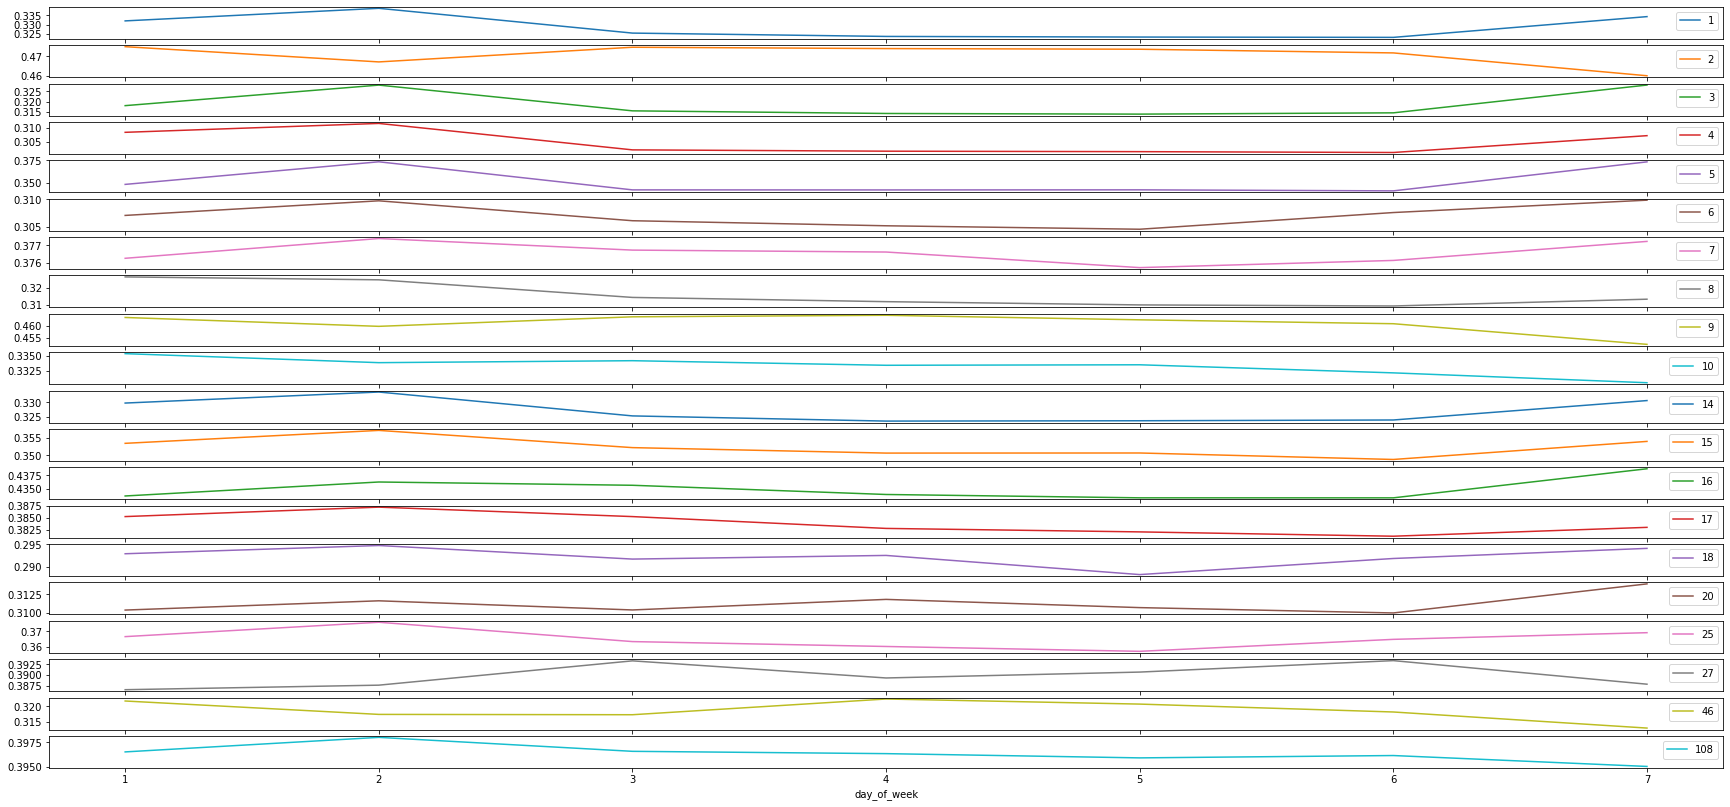

In [17]:
fig, ax = plt.subplots(figsize=(30, 14))
# plt.xlabel('day_of_week', fontsize=15)
# plt.ylabel('amnt', fontsize=15)
# plt.title("Distribution of transaction amount by day of the week according to Top 20 mcc-codes", fontsize=20);
pd.pivot_table(pd_mcc_df[pd_mcc_df['mcc'].isin(pd_mcc_df['mcc'].value_counts()[:n].index.tolist())].reset_index(),
               index='day_of_week', columns='mcc', values='amnt'
              ).plot(ax=ax, subplots=True);
plt.show();

* <i> Посмотрим, как коррелирует mcc с другими признаками в датафрейме на примере идетификатора app_id = 1

In [38]:
pd_df_1 = df.filter(col('app_id') == 1).toPandas()

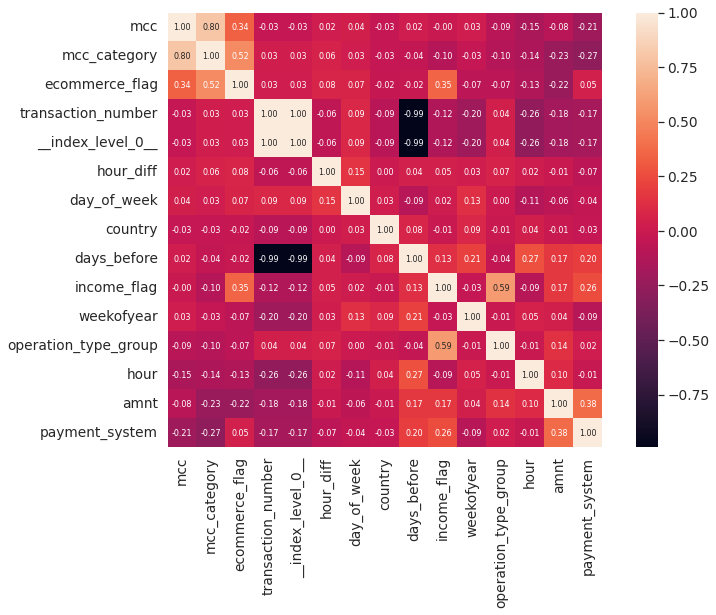

In [39]:
k = 15
corrmat = pd_df_1.corr(method='spearman')
cols = corrmat.nlargest(k, 'mcc').index
cm = np.corrcoef(pd_df_1[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<b> 4. Проведем кластеризацию клиентов в разрезе значений mcc-кодов (mcc) и сумм транзакций (amnt) 

In [12]:
mcc_df.columns

['app_id', 'amnt', 'mcc', 'mcc_category', 'day_of_week']

In [13]:
vectorAssembler = VectorAssembler(inputCols = ['mcc', 'amnt'], outputCol = 'mcc_features')
mcc_df_km = vectorAssembler.transform(mcc_df.filter(col('amnt') != 0.0))
mcc_df_km = mcc_df_km.select(['app_id', 'mcc_features'])

In [14]:
mcc_df_km.show(5)

+------+--------------------+
|app_id|        mcc_features|
+------+--------------------+
|     0|[2.0,0.4654254330...|
|     0|[2.0,0.5211518246...|
|     0|[10.0,0.356078353...|
|     0|[2.0,0.5168336566...|
|     0|[2.0,0.2589723745...|
+------+--------------------+
only showing top 5 rows



In [16]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [38]:
# Подберем оптимальное значение k в диапозоне от 2 до 14
cost = list(range(2,15))
for k in range(2, 15):
    evaluator = ClusteringEvaluator()
    kmeans = KMeans(featuresCol='mcc_features').setK(k).setSeed(23)
    km_model = kmeans.fit(mcc_df_km)
    predictions = km_model.transform(mcc_df_km)
    # computeCost: вычислить сумму квадрата расстояния между входной точкой и соответствующим центром кластера.
    cost[k-2] = evaluator.setDistanceMeasure('squaredEuclidean').setFeaturesCol("mcc_features").setPredictionCol("prediction").evaluate(predictions)

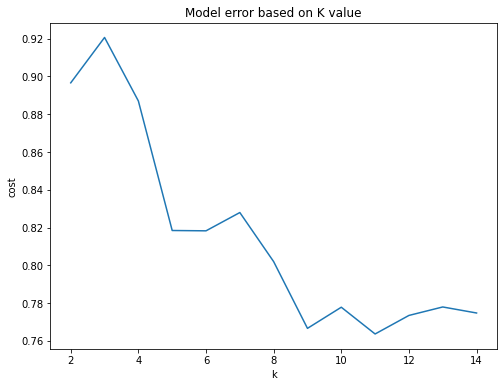

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.set_title('Model error based on K value')
ax.plot(range(2,15), cost);

In [47]:
# Создадим модель, задав параметр k = 9
kmeans = KMeans(featuresCol='mcc_features').setK(9).setSeed(23)
km_model = kmeans.fit(mcc_df_km)
centers = km_model.clusterCenters()

In [48]:
# Центральная точка кластера
centers

[array([4.14260153, 0.32210142]),
 array([108.        ,   0.39673756]),
 array([57.31288984,  0.40152442]),
 array([29.30972731,  0.38110382]),
 array([43.56443366,  0.38024264]),
 array([17.12232917,  0.35046799]),
 array([1.43886493, 0.39167784]),
 array([10.51334966,  0.34092051]),
 array([7.92209798, 0.3942624 ])]

In [49]:
# Получим результаты прогнозирования кластера
transformed = km_model.transform(mcc_df_km).select('app_id', 'prediction')

# Объединим таблицы
df_pred = mcc_df.join(transformed, 'app_id')

In [50]:
df_pred.show(10)

+------+-------------------+---+------------+-----------+----------+
|app_id|               amnt|mcc|mcc_category|day_of_week|prediction|
+------+-------------------+---+------------+-----------+----------+
|     1|0.42105610477663846|  1|           1|          3|         6|
|     1|0.42105610477663846|  1|           1|          3|         6|
|     1|0.42105610477663846|  1|           1|          3|         6|
|     1|0.42105610477663846|  1|           1|          3|         6|
|     1|0.42105610477663846|  1|           1|          3|         0|
|     1|0.42105610477663846|  1|           1|          3|         2|
|     1|0.42105610477663846|  1|           1|          3|         6|
|     1|0.42105610477663846|  1|           1|          3|         6|
|     1|0.42105610477663846|  1|           1|          3|         6|
|     1|0.42105610477663846|  1|           1|          3|         6|
+------+-------------------+---+------------+-----------+----------+
only showing top 10 rows

